# Aplicação do Algoritmo PageRank

**Grupo** <br />
Bruno Monteiro   <br />
Harrison Santos  <br />
Rafael Guimarães <br />


**Disciplina:** Métodos Numéricos <br />
**Professor:** Paulo Ribeiro

Nesse arquivo iremos introduzir o **algoritmo de PageRank** baseado na implementação da
biblioteca networkx [[1]](https://networkx.github.io/)

e numa aplicaçao da Medium.com [[2]](https://medium.com/analytics-vidhya/the-algorithm-behind-google-search-an-implementation-with-python-d6418023bbd9)

PageRank (PR) é um algoritmo usado pela Pesquisa do Google para classificar sites nos resultados de seus mecanismos de pesquisa. é uma maneira de medir a importância das páginas do site. De acordo com o Google: 


O PageRank funciona contando o número e a qualidade dos links de uma página para determinar uma estimativa aproximada da importância do site. A suposição subjacente é que os sites mais importantes provavelmente receberão mais links de outros sites.


In [54]:
def pagerank(G, alpha=0.85, personalization=None, 
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight', 
             dangling=None): 
    
    if len(G) == 0: 
        return {} 
  
    if not G.is_directed(): 
        D = G.to_directed() 
    else: 
        D = G 
  
    # Create a copy in (right) stochastic form 
    W = nx.stochastic_graph(D, weight=weight) 
    N = W.number_of_nodes() 
  
    # Choose fixed starting vector if not given 
    if nstart is None: 
        x = dict.fromkeys(W, 1.0 / N) 
    else: 
        # Normalized nstart vector 
        s = float(sum(nstart.values())) 
        x = dict((k, v / s) for k, v in nstart.items()) 
  
    if personalization is None: 
  
        # Assign uniform personalization vector if not given 
        p = dict.fromkeys(W, 1.0 / N) 
    else: 
        missing = set(G) - set(personalization) 
        if missing: 
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing) 
        s = float(sum(personalization.values())) 
        p = dict((k, v / s) for k, v in personalization.items()) 
  
    if dangling is None: 
  
        # Use personalization vector if dangling vector not specified 
        dangling_weights = p 
    else: 
        missing = set(G) - set(dangling) 
        if missing: 
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing) 
        s = float(sum(dangling.values())) 
        dangling_weights = dict((k, v/s) for k, v in dangling.items()) 
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0] 
  
    # power iteration: make up to max_iter iterations 
    for _ in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0) 
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
  
            # this matrix multiply looks odd because it is 
            # doing a left multiply x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight] 
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n] 
  
        # check convergence, l1 norm 
        err = sum([abs(x[n] - xlast[n]) for n in x]) 
        if err < N*tol: 
            return x 
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter) 

**Descrição do Algoritmo:**

De acordo com [1],  O algoritmo PageRank gera uma distribuição de probabilidade usada para representar a probabilidade de uma pessoa clicar aleatoriamente nos links e chegar a qualquer página em particular. O PageRank pode ser calculado para coleções de documentos de qualquer tamanho. Supõe-se em vários trabalhos de pesquisa que a distribuição é dividida igualmente entre todos os documentos da coleção no início do processo computacional. Os cálculos do PageRank requerem várias passagens, chamadas "iterações", através da coleção para ajustar valores aproximados do PageRank para refletir mais de perto o valor verdadeiro teórico. 

O código acima é a função que foi implementada na biblioteca networkx. Para utiliza-la vamos aos imports

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Inicialmente, como não há links entre nossos sites A, B, C, D, a idéia é que, no momento, todos eles sejam igualmente importantes.

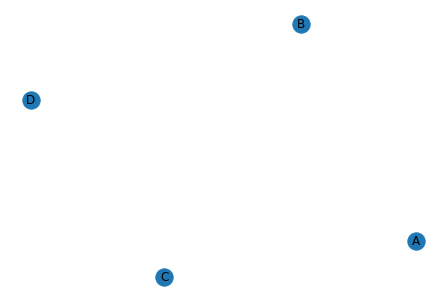

In [78]:
DG = nx.DiGraph()
DG.add_nodes_from("ABCD")
nx.draw(DG,with_labels=True)
plt.show()

O algoritmo PageRank gera uma distribuição de probabilidade usada para representar a probabilidade de uma pessoa clicar aleatoriamente nos links chegar a qualquer página em particular. Portanto, a saída será um vetor cujo somatório dos componentes é igual a 1.

**Observação**: o parâmetro _alfa_ é o chamado fator de amortecimento. Isso ocorre porque o algoritmo deve levar em consideração o fato de que um surfista imaginário que clica aleatoriamente nos links acaba parando de clicar. A probabilidade, a qualquer momento, de a pessoa continuar é o fator de amortecimento alfa e o **Google o definiu 0,85** como padrão.

In [79]:
pr = nx.pagerank(DG, alpha=0.85)
pr

{'A': 0.25, 'B': 0.25, 'C': 0.25, 'D': 0.25}

Vamos adicionar alguns links entre nossos nós. 

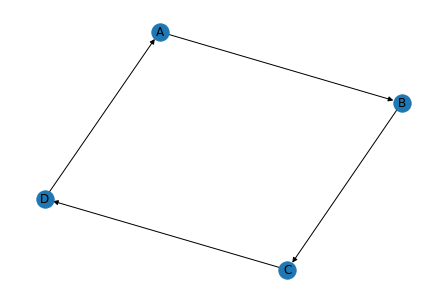

In [81]:
DG.add_weighted_edges_from([("A", "B", 1), ("B", "C", 1),("C","D",1),("D","A",1)]) 
nx.draw(DG,with_labels=True)

Para entender a matemática por trás do PageRank, precisamos introduzir um conceito adicional, que é a **matriz de links.** Trata-se de uma matriz quadrada com dimensões iguais ao número de nós e descreve, para cada nó, seus links interno e externo. Podemos ler a matriz em duas direções: 

    - Por Linhas: Mostra quais são os links internos para cada nó
    - Por Colunas: Mostra quaiss ão os links externos para cada nó

In [82]:
A=np.matrix([(0,0,0,1),(1,0,0,0),(0,1,0,0),(0,0,1,0)])
A

matrix([[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]])

se um nó tiver $k$ arestas de saída, ele passará $\frac{1}{k}$ de sua importância para cada um dos nós aos quais está vinculado.

A idéia do PageRank é que, por meio de um processo iterativo, possamos atualizar o vetor de classificação (inicializado com links com o mesmo peso) com a matriz A. Ou seja, a nova probabilidade de nossos sites após uma iteração será o vetor $v ' = A v.$ O vetor resultante após a iteração k é igual a

$$v_{1} = Av_{0}$$ <br />
$$v_{2} = A^{2}v_{0} = A(Av_{0}) = Av_{1}$$ <br />
$$\ldots$$ <br />
$$v_{k} = A^{k}v_{0} = Av_{k-1}$$ <br />

e convergirá para o vetor de classificação da rede analisada. Vamos analizar o seguinte exemplo.

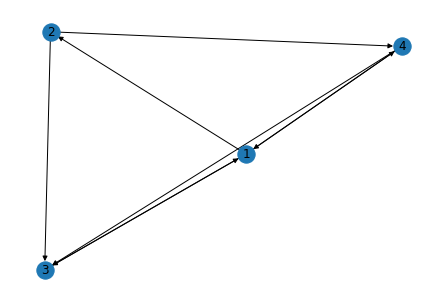

In [85]:
DG_test = nx.DiGraph()
DG_test.add_nodes_from([1,2,3,4])
DG_test.add_weighted_edges_from([(1,3,1), (1,4, 1),(1,2,1),(2,3,1),(2,4,1),(3,1,1),(4,1,1),(4,3,1)])
nx.draw(DG_test, with_labels=True)

In [84]:
# A matriz de links terá a seguinte aparência:

B=np.matrix([(0,0,1,0.5),(1/3,0,0,0),(1/3,0.5,0,0.5),(1/3,0.5,0,0)])
B

matrix([[0.        , 0.        , 1.        , 0.5       ],
        [0.33333333, 0.        , 0.        , 0.        ],
        [0.33333333, 0.5       , 0.        , 0.5       ],
        [0.33333333, 0.5       , 0.        , 0.        ]])

Agora, se aplicarmos o algoritmo PageRank (observe que será defido alpha = 1, para que não consideremos a possibilidade de parar de clicar no link)

In [86]:
pr=nx.pagerank(DG_test,alpha=1)
pr

{1: 0.38709615908859496,
 2: 0.12903204605249047,
 3: 0.29032302109901886,
 4: 0.193548773759895}

Obtemos o mesmo resultado da seguinte iteração (com k = 1000) para atualizar nosso vetor de classificação:

In [87]:
np.array((B**1000)*A.T)

array([[0.38709677, 0.38709677, 0.38709677, 0.38709677],
       [0.12903226, 0.12903226, 0.12903226, 0.12903226],
       [0.29032258, 0.29032258, 0.29032258, 0.29032258],
       [0.19354839, 0.19354839, 0.19354839, 0.19354839]])

vamos ver como nosso algoritmo funciona em uma rede mais complexa, digamos com 10 nós:

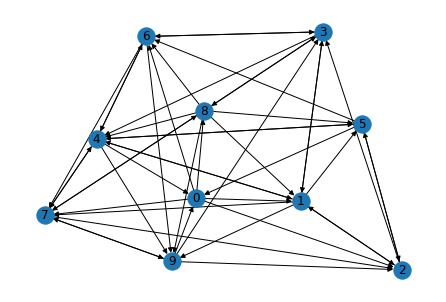

In [72]:
G=nx.fast_gnp_random_graph(10,0.5,directed=True)
nx.draw(G,with_labels=True)

In [88]:
pr=nx.pagerank(G,alpha=0.85)
rank_vector=np.array([[*pr.values()]])
best_node=np.argmax(rank_vector)
print("O nó mais popular é {}".format(best_node))

O nó mais popular é 4
